# Performing Exploratory Data Analysis for Student Retention

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from tools.utils import combine_columns, compute_feature_importance, standard_units

## Introduction

The purpose of this project is to analyze the factors that influence the retention rate of a school and how closely they relate to retention rate. Retention rate is a critical indicator of a school's effectiveness and success in keeping students enrolled and engaged in their academic pursuits. In this project, we will examine various factors that could potentially impact retention rates, such as the control of the school(public, non-profit private and profit private), in-state/out-state tuition & fee, the percentage of individuals receiving federal loans, race, parent education and so on.

## Data Description

The data used in this analysis will be obtained from the College Scorecard, a comprehensive dataset maintained by the United States Department of Education. The dataset includes information on over 7,000 higher education institutions in the United States, spanning a period of more than two decades.

The dataset includes a range of variables, including institutional characteristics such as size, location, and type of degree programs offered, as well as information on student outcomes such as graduation rates, earnings, and debt levels. In addition, the dataset includes information on institutional net price, which is the average cost of attendance after accounting for grants and scholarships.

Overall, the data provides a comprehensive view of the factors that impact retention rates in higher education institutions and will be used to inform strategies for improving retention rates and student success.

## Loading in Data

In [2]:
# Load in cleaned data
data = pd.read_csv("data/Most-Recent-Cohorts-Institution-filtered.csv")
data = data.drop('Unnamed: 0', axis=1)

Since we are focusing on retention rates, we are renaming the variable names for the "First-time, full-time student retention rate at four-year institutions" and "First-time, full-time student retention rate at less-than-four-year institutions" in order to improve identification of the main variables.

In [3]:
# First-time, full-time student retention rate at four-year institutions
four_yr_retention = data.RET_FT4

# First-time, full-time student retention rate at less-than-four-year institutions
less_four_yr_retention = data.RET_FTL4

## Important Note: __Null Values__

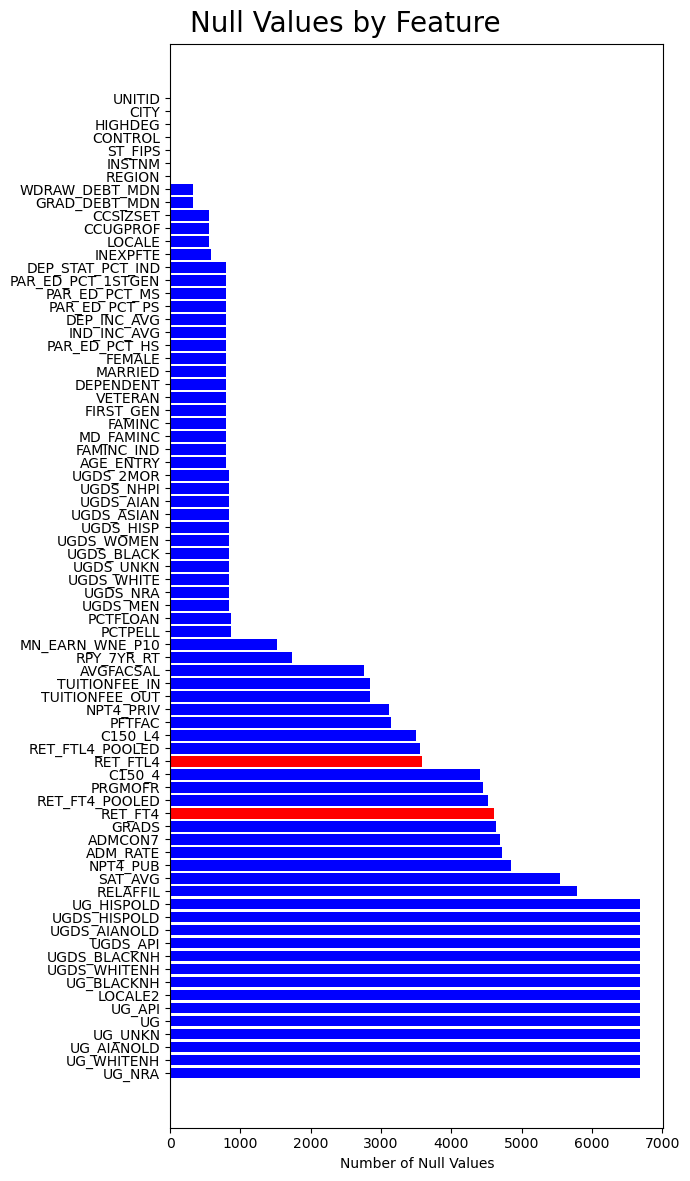

In [4]:
nulls_by_column = data.isna().sum().sort_values(ascending=False)

colors = np.tile('b', len(nulls_by_column))

retention = ["RET_FT4", "RET_FTL4"]
retention_vars_mask = pd.Series(nulls_by_column.index).isin(retention).values
colors[retention_vars_mask] = np.tile('r', len(retention))

fig, ax = plt.subplots(figsize=(7, 12))
ax.barh(np.arange(-5, len(nulls_by_column)-5), nulls_by_column.values, color=colors)
ax.set_yticks(np.arange(-5, len(nulls_by_column)-5), labels=nulls_by_column.index)
ax.set_xlabel("Number of Null Values")
fig.suptitle("Null Values by Feature", size=20)
fig.savefig('figures/null_values.png')
fig.tight_layout();

It is important to note that we will be dealing with a high amount of null values, especially when looking at the number of programs. In fact, the last several columns listed are entirely null.

## Histograms for Overall Retention Rates

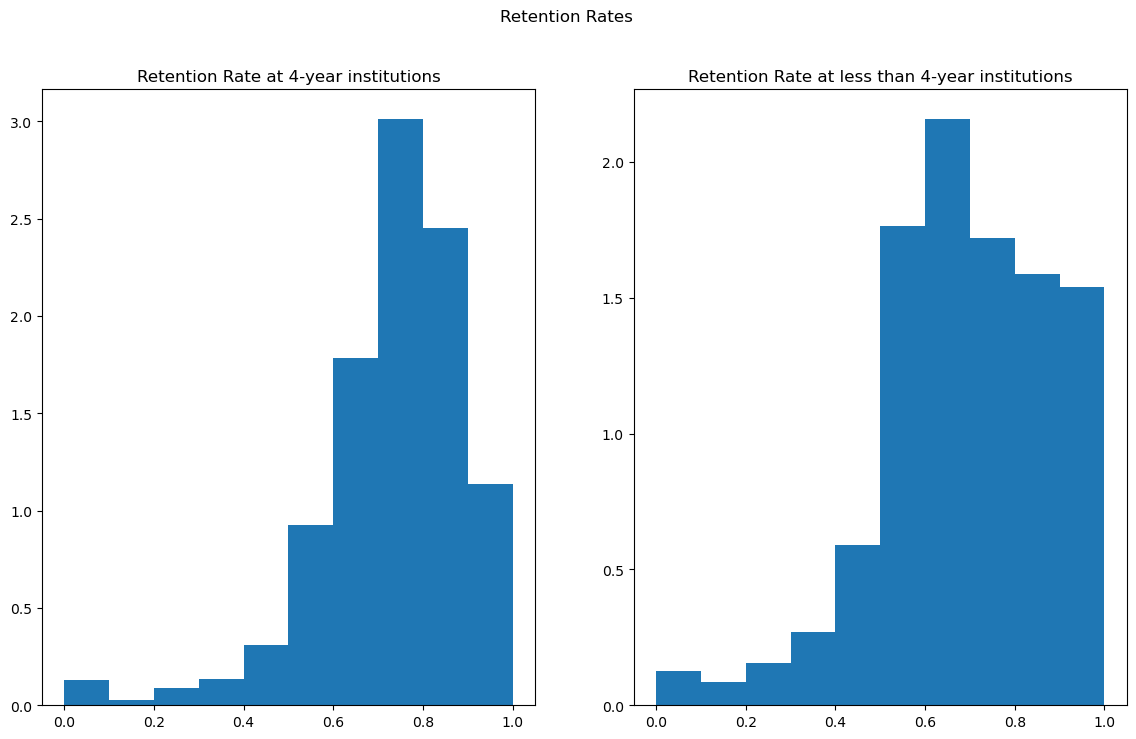

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(four_yr_retention, density = True)

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(less_four_yr_retention, density = True)

plt.savefig('figures/overall_retention_histogram.png')
plt.show()

Based on the histograms, we notice that retention rates for both 4-year and less than 4-year institutions appear to have a left-skewed distribution. However, less than 4-year institutions has more density contained within the higher retention rates compared to the 4-year institutions.

We will now explore sets of relevant variables and their relation to the retention rates.

## Explore Control of the school

#### Public Schools

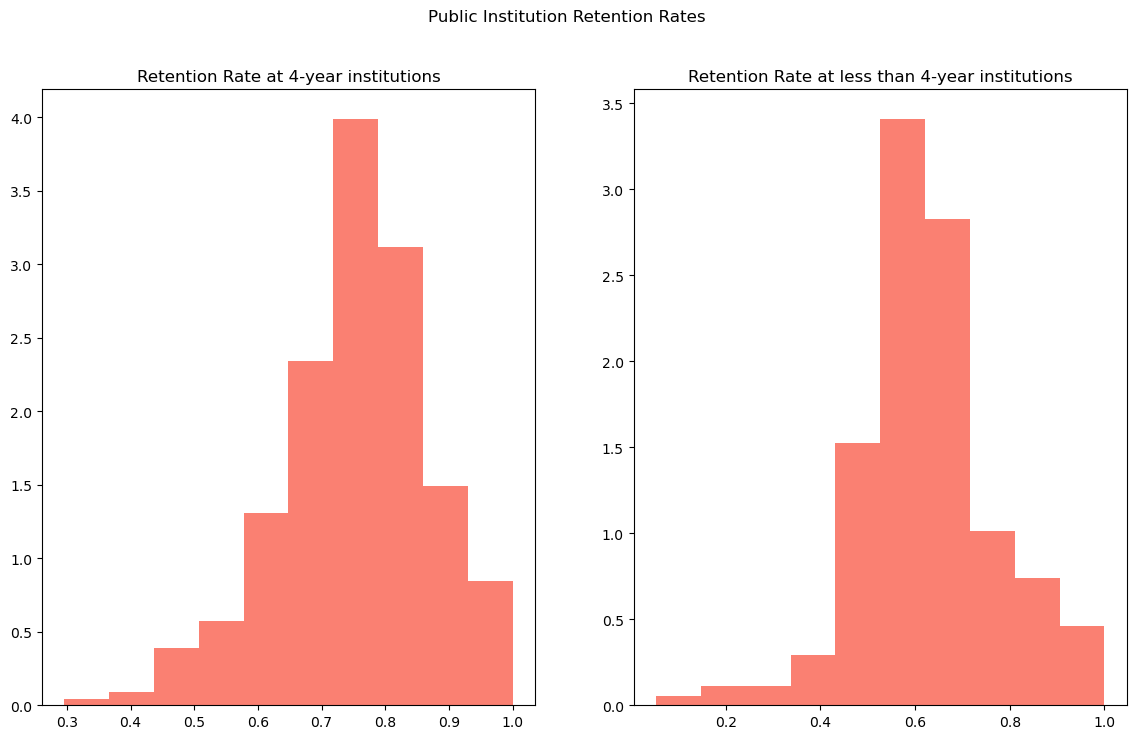

In [6]:
public = data.loc[data["CONTROL"] == 1]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Public Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(public.RET_FT4, density = True, color = "salmon")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(public.RET_FTL4, density = True, color = "salmon")

plt.savefig('figures/retention_public.png');
plt.show()

**For public schools, the retention rates severely declines as the left-skewed distribution transforms into a normal distribution. The change is more noticeable in the retention rates of less than 4-year public institutions.**

#### Private Non-Profit

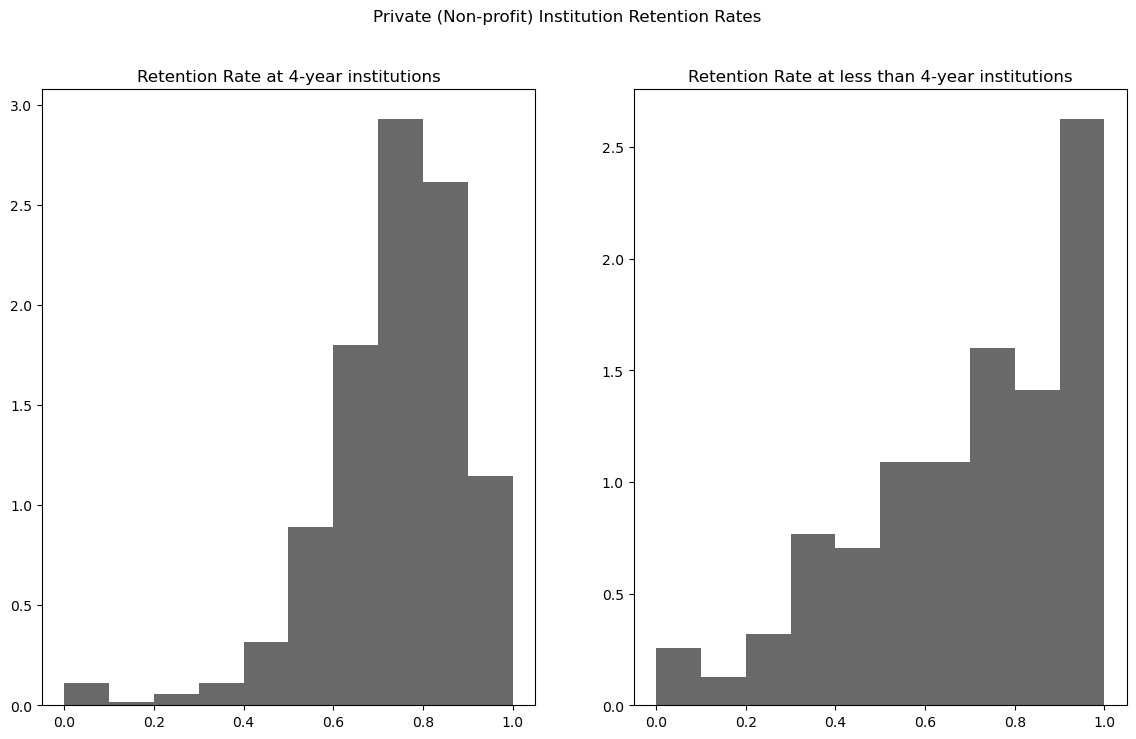

In [7]:
private_non_profit = data.loc[data["CONTROL"] == 2]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Private (Non-profit) Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(private_non_profit.RET_FT4, density = True, color = "dimgray")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(private_non_profit.RET_FTL4, density = True, color = "dimgray")

plt.savefig('figures/retention_private_non_profit.png')
plt.show()

**In the case of non-profit private institutions, the retention rates for 4-year institutions appears to remain with the same. However, the retention for less than 4-year institution increases with the density focused in the 100% retention rate.** 

#### Private For-Profit

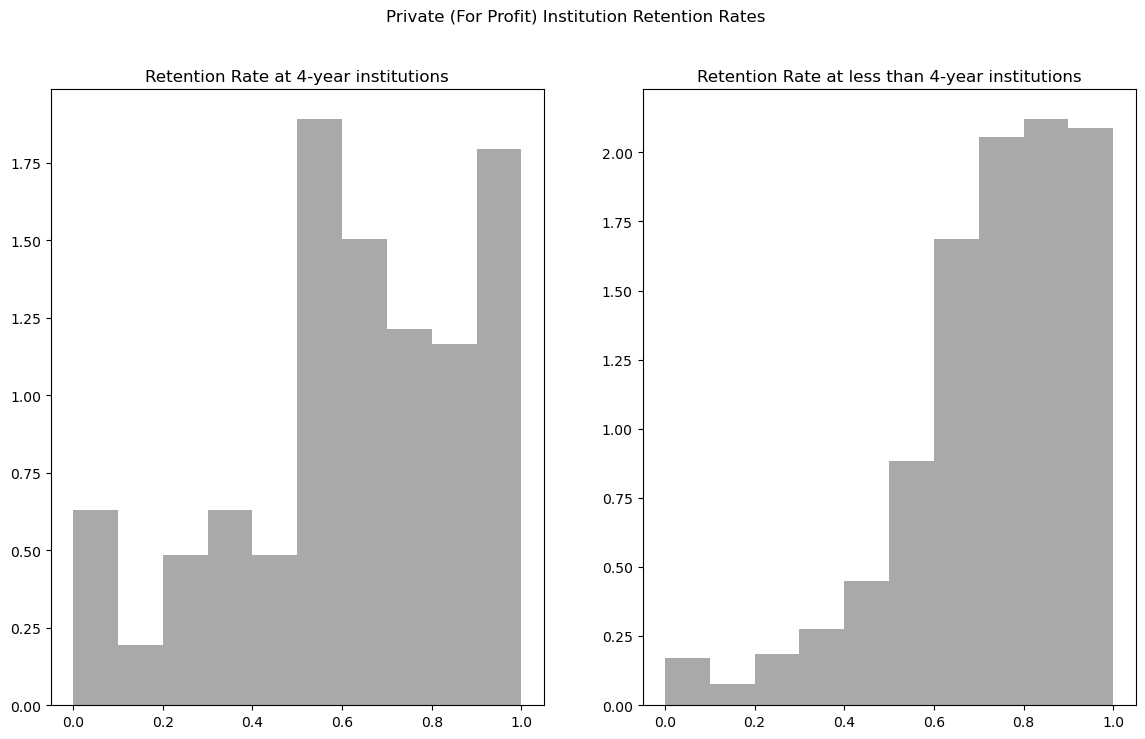

In [8]:
private_profit = data.loc[data["CONTROL"] == 3]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Private (For Profit) Institution Retention Rates')

ax1.set_title('Retention Rate at 4-year institutions')
ax1.hist(private_profit.RET_FT4, density = True, color = "darkgray")

ax2.set_title('Retention Rate at less than 4-year institutions')
ax2.hist(private_profit.RET_FTL4, density = True, color = "darkgray")

plt.savefig('figures/retention_private_profit.png')
plt.show()

**As for-profit private institutions, the retention rate for 4-year institutions maintains a left skewed distribution. However, a spike appears around the the 50% mark which indicates a slightly worse retention than the overall. As for the less than 4-year institution, the retention increases similarly to the non-profit institution as the density is focused on the higher end of the retention rates.**

## Explore In state and Out state Tuition

In [9]:
# data only with tuition fee of in state and out state, four-year institutions and less than four-year institutions
tuition_data = data[['RET_FT4', 'RET_FTL4', 'TUITIONFEE_IN','TUITIONFEE_OUT']]
tuition_data.head()

,RET_FT4,RET_FTL4,TUITIONFEE_IN,TUITIONFEE_OUT
0,0.5403,NaN,10024.0,18634.0
1,0.8640,NaN,8568.0,20400.0
2,0.5000,NaN,6950.0,6950.0
3,0.8180,NaN,11338.0,23734.0
4,0.6202,NaN,11068.0,19396.0


First, we can take a look at what difference in the distribution between in-state and out-state tuition.

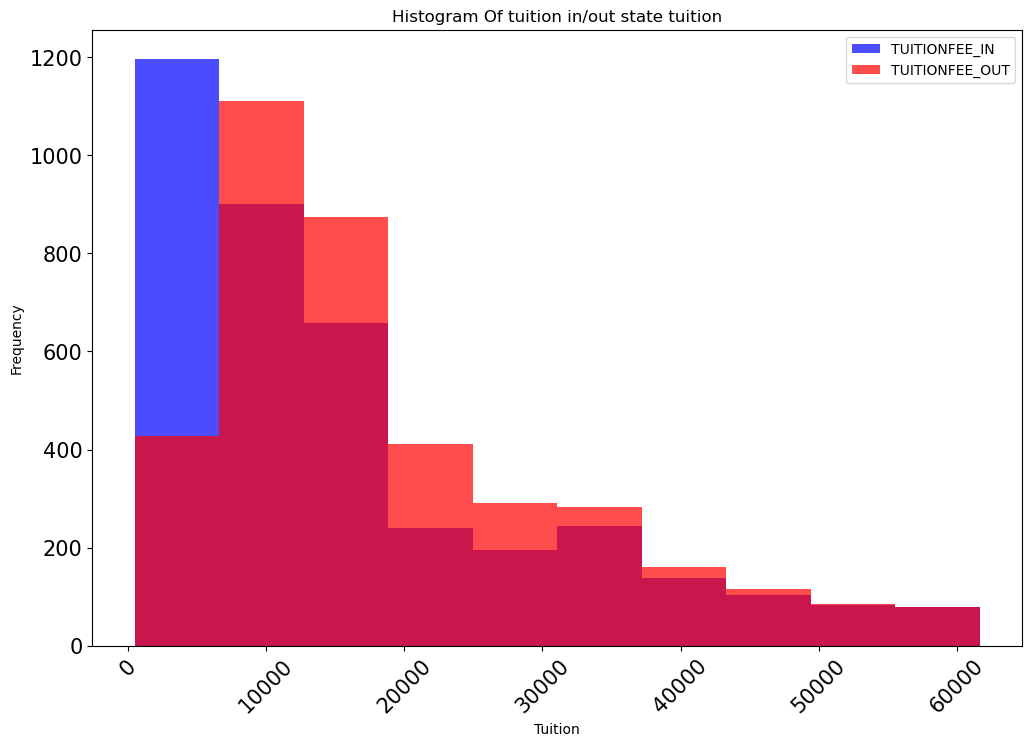

In [10]:
tuition_data_inout = tuition_data[['TUITIONFEE_IN','TUITIONFEE_OUT']]
tuition_data_inout.plot(kind='hist',
        alpha=0.7,
        title='Histogram Of tuition in/out state tuition',
        rot=45,
        figsize=(12,8),
        fontsize=15, 
        color=['blue', 'r'])
plt.xlabel('Tuition');

plt.savefig('figures/in_out_tuition.png')
plt.show()

From the Histogram above, in state more concentrated in the low cost segment. And more people are out of state than in state in every range except 0 to 5,000. It can be seen that students out of state need to pay more fees than those in state. The same conclusion can be found when we directly compare the mean and median of students in state and out state, that is, both the mean and median of students in out state are higher than those in state.

After looking at the difference in distribution between in state tuition & fee and out state tuition & fee, we can analysis them combine with retention rate. Now take a look at if in/out state tuition&fee affect retention rate.

In [11]:
in_FT4 = data[['RET_FT4', 'TUITIONFEE_IN']]
in_FTL4 = data[['RET_FTL4', 'TUITIONFEE_IN']]
out_FT4 = data[['RET_FT4', 'TUITIONFEE_OUT']]
out_FTL4 = data[['RET_FTL4', 'TUITIONFEE_OUT']]

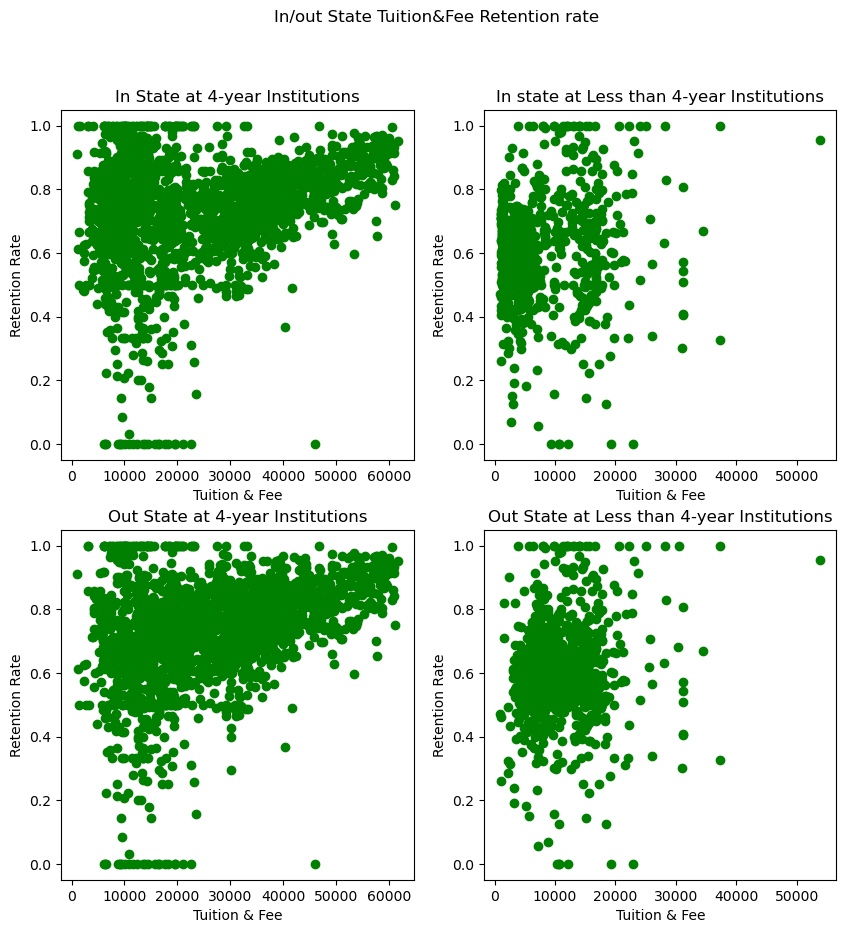

In [12]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle('In/out State Tuition&Fee Retention rate')

# make a graph for in state tuition & fee and 4 year institutions
ax1.set_title('In State at 4-year Institutions')
ax1.set_xlabel('Tuition & Fee')
ax1.set_ylabel('Retention Rate')
ax1.scatter(in_FT4.TUITIONFEE_IN, in_FT4.RET_FT4,color ='green')

# make a graph for in state tuition & fee and less than 4 year institutions
ax2.set_title('In state at Less than 4-year Institutions')
ax2.set_xlabel('Tuition & Fee')
ax2.set_ylabel('Retention Rate')
ax2.scatter(in_FTL4.TUITIONFEE_IN, in_FTL4.RET_FTL4,color ='green')

# make a graph for out state tuition & fee and 4 year institutions
ax3.set_title('Out State at 4-year Institutions')
ax3.set_xlabel('Tuition & Fee')
ax3.set_ylabel('Retention Rate')
ax3.scatter(out_FT4.TUITIONFEE_OUT, out_FT4.RET_FT4,color ='green')

# make a graph for out state tuition & fee and less than 4 year institutions
ax4.set_title('Out State at Less than 4-year Institutions')
ax4.set_xlabel('Tuition & Fee')
ax4.set_ylabel('Retention Rate')
ax4.scatter(out_FTL4.TUITIONFEE_OUT, out_FTL4.RET_FTL4,color ='green')

plt.savefig('figures/retention_in_out_tuition.png')
plt.show()

We use the correlation coefficient(r) measures the strength of the linear relationship between two variables. Graphically, it measures how clustered the scatter diagram is around a straight line.

In [13]:
standard_tuition_data = tuition_data.assign(standard_RET_FT4=standard_units(tuition_data.RET_FT4),
                       standard_RET_FTL4=standard_units(tuition_data.RET_FTL4),
                       standard_TUI_IN=standard_units(tuition_data.TUITIONFEE_IN),
                       standard_TUI_OUT=standard_units(tuition_data.TUITIONFEE_OUT))
standard_tuition_data.head()

,RET_FT4,RET_FTL4,TUITIONFEE_IN,TUITIONFEE_OUT,standard_RET_FT4,standard_RET_FTL4,standard_TUI_IN,standard_TUI_OUT
0,0.5403,NaN,10024.0,18634.0,-1.139438,NaN,-0.422876,-0.038961
1,0.8640,NaN,8568.0,20400.0,0.794970,NaN,-0.526098,0.095119
2,0.5000,NaN,6950.0,6950.0,-1.380268,NaN,-0.640805,-0.926044
3,0.8180,NaN,11338.0,23734.0,0.520077,NaN,-0.329721,0.348246
4,0.6202,NaN,11068.0,19396.0,-0.661961,NaN,-0.348862,0.018892


In [14]:
# the correlation coefficient(r) of 4-year instituion with in-state tuition
r_4_in_state = np.mean(standard_tuition_data.standard_RET_FT4 * standard_tuition_data.standard_TUI_IN)
# the correlation coefficient(r) of 4-year instituion with out-state tuition
r_4_out_state = np.mean(standard_tuition_data.standard_RET_FT4 * standard_tuition_data.standard_TUI_OUT)
# the correlation coefficient(r) of less than 4-year instituion with in-state tuition
r_less_4_in_state = np.mean(standard_tuition_data.standard_RET_FTL4 * standard_tuition_data.standard_TUI_IN)
# the correlation coefficient(r) of less than 4-year instituion with out-state tuition
r_less_4_out_state = np.mean(standard_tuition_data.standard_RET_FTL4 * standard_tuition_data.standard_TUI_OUT)

print("The correlation coefficient of 4-year instution for in-state tuition & fee is " + str(r_4_in_state)+".")
print("The correlation coefficient of 4-year instution for out-state tuition & fee is " + str(r_4_out_state)+ ".")
print("The correlation coefficient of less than 4-year instution for in-state tuition & fee is "+ str(r_less_4_in_state)+".")
print("The correlation coefficient of less than 4-year instution for out-state tuition & fee is "+ str(r_less_4_out_state)+".")

The correlation coefficient of 4-year instution for in-state tuition & fee is 0.27829321886510244.
The correlation coefficient of 4-year instution for out-state tuition & fee is 0.3726884580745627.
The correlation coefficient of less than 4-year instution for in-state tuition & fee is 0.32978043799834184.
The correlation coefficient of less than 4-year instution for out-state tuition & fee is 0.3277732356542793.


**Based on the correlation coefficient, there is a weak relationship between in/out-state tuition&fee with retention rate at either four-year and less-than-four-year institutions.**

## Explore Percentage of individuals receiving federal loans

Now we will focus on if the percent of all undergraduate students receiving federal student loan affect the the "First-time, full-time student retention rate at four-year institutions" and "First-time, full-time student retention rate at less-than-four-year institutions". We can filter out the related data.

In [15]:
# data only with tuition fee of in state and out state, four-year institutions and less than four-year institutions
percent_loan_data = data[['RET_FT4', 'RET_FTL4', 'PCTFLOAN']]
percent_loan_data.head()

,RET_FT4,RET_FTL4,PCTFLOAN
0,0.5403,NaN,0.7504
1,0.8640,NaN,0.4688
2,0.5000,NaN,0.8493
3,0.8180,NaN,0.3855
4,0.6202,NaN,0.7805


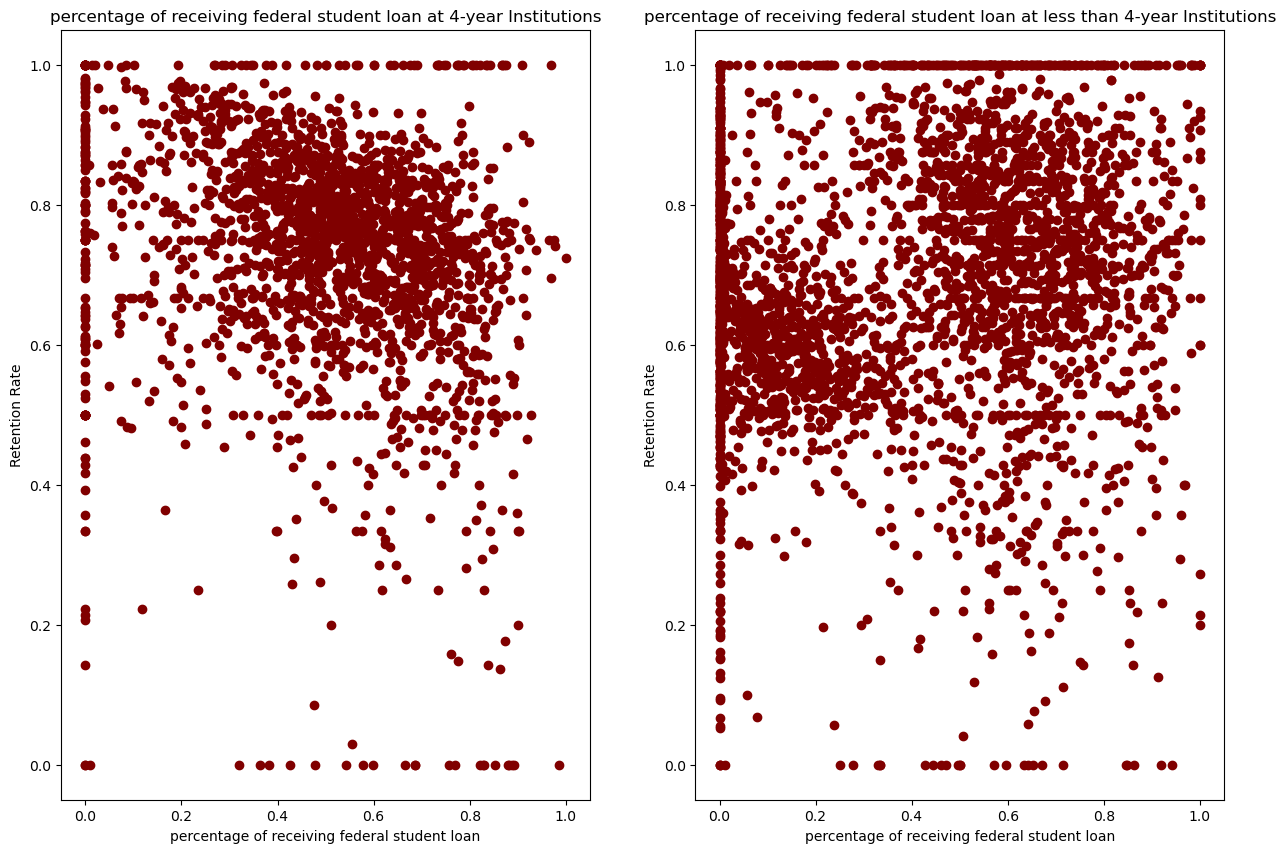

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,10))
fig.suptitle('')

ax1.set_title('percentage of receiving federal student loan at 4-year Institutions')
ax1.set_xlabel('percentage of receiving federal student loan')
ax1.set_ylabel('Retention Rate')
ax1.scatter(percent_loan_data.PCTFLOAN, percent_loan_data.RET_FT4,color ='maroon')

ax2.set_title('percentage of receiving federal student loan at less than 4-year Institutions')
ax2.set_xlabel('percentage of receiving federal student loan')
ax2.set_ylabel('Retention Rate')
ax2.scatter(percent_loan_data.PCTFLOAN, percent_loan_data.RET_FTL4,color ='maroon')

plt.savefig('figures/retention_percentage_federal_loan.png')
plt.show()

In [17]:
standard_percent_loan_data = tuition_data.assign(standard_RET_FT4=standard_units(percent_loan_data.RET_FT4),
                       standard_RET_FTL4=standard_units(percent_loan_data.RET_FTL4),
                       standard_percent_loan=standard_units(percent_loan_data.PCTFLOAN))
standard_percent_loan_data
# the correlation coefficient(r) of percentage of receiving federal student loan at 4-year Institutions
r_percent_loan_4year = np.mean(standard_percent_loan_data.standard_RET_FT4 * standard_percent_loan_data.standard_percent_loan)
print("The correlation coefficient of percentage of receiving federal student loan at 4-year Institutions is "+ str(r_percent_loan_4year))
# the correlation coefficient(r) of percentage of receiving federal student loan at less than 4-year Institutions
r_percent_loan_l4year = np.mean(standard_percent_loan_data.standard_RET_FTL4 * standard_percent_loan_data.standard_percent_loan)
print("The correlation coefficient of percentage of receiving federal student loan at less than 4-year Institutions is "+str(r_percent_loan_l4year))

The correlation coefficient of percentage of receiving federal student loan at 4-year Institutions is -0.1654776936242682
The correlation coefficient of percentage of receiving federal student loan at less than 4-year Institutions is 0.14346890122719802


**By the scatter above and the correlation coefficient,we think the percentage of receiving federal student loan at 4-year Institutions and less than 4-year Institutions graph looks like not really match the positive or negative relationship with retention rate. Therefore, we think the percentage of receiving federal student loan at 4-year or less than 4-year Institutions not really influence student's retention rate.**

## Explore Parent Education

* ```PAR_ED_PCT_MS``` is the percentage of parents who have a middle school education

* ```PAR_ED_PCT_HS``` is the percentage of parents who have a high school education

* ```PAR_ED_PCT_PS``` is the percentage of parents who have some college school education

Only about 10% of these columns' values are null, so we can trust our analysis of these variables with greater certainty.

However, note that the null values occur for exactly the same rows, meaning that they likely share some trait or may come from a different generating distribution. We will drop these values for now as they represent a minority of the dataset

In [18]:
prop_null = data.PAR_ED_PCT_MS.isna().sum() / len(data.PAR_ED_PCT_MS)
null_MS = data.PAR_ED_PCT_MS.isna().sum()
null_HS = data.PAR_ED_PCT_HS.isna().sum()
null_PS = data.PAR_ED_PCT_PS.isna().sum()
print("prop null: ", prop_null)

#each column has the same number of nulls.
print("number of nulls for MS, HS, college (PS) respectively: ", null_MS, null_HS, null_PS)

prop null:  0.11824577159107919
number of nulls for MS, HS, college (PS) respectively:  790 790 790


In [19]:
#each column has nulls in the exact same row as the other columns
null_count = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].isna().apply(all, axis=1).sum()
print(f"All 3 columns have {null_count} overlapping nulls")

All 3 columns have 790 overlapping nulls


There are also "PrivacySuppressed" values which act as null values. They still represent a minority of the dataset so we will continue our analysis. 

In [20]:
print("proportion of PAR_ED_PCT_PS which is PrivacySuppressed: ", data.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum() / len(data))

proportion of PAR_ED_PCT_PS which is PrivacySuppressed:  0.11465349498578058


Note that once again these null-like values contain a pattern. Rows which are "PrivacySuppressed" for college education ```PAR_ED_PCT_PS``` tend to be privacy suppressed in highschool education ```PAR_ED_PCT_HS``` and middle school education ```PAR_ED_PCT_PS```. Similarly, rows which are "PrivacySuppressed" for highschool education ```PAR_ED_PCT_HS``` tend to be privacy suppressed in middleschool education ```PAR_ED_PCT_MS```. 

This may have something to do with higschool requiring a middleschool education, and college requiring a highschool education. It may also have something to do with the school's size, as having a smaller population makes it easier to re-identify individuals from aggregate data. 

In [21]:
PS_MS = data.PAR_ED_PCT_MS.str.match("PrivacySuppressed").sum()
PS_HS = data.PAR_ED_PCT_HS.str.match("PrivacySuppressed").sum()
PS_PS = data.PAR_ED_PCT_PS.str.match("PrivacySuppressed").sum()
print("number of PrivacySuppressed for MS, HS, college (PS) respectively: ", PS_MS, PS_HS, PS_PS)

number of PrivacySuppressed for MS, HS, college (PS) respectively:  1986 1979 766


In [22]:
# 757 of the college-education column's 766 PrivacySuppressed values are also PrivacySuppressed in the HS and MS education columns 
ps_and_hs_and_ms = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()
print(f"The College, Highschool, and Middleschool columns share {ps_and_hs_and_ms} nulls of Middleschool's {PS_PS} nulls")

The College, Highschool, and Middleschool columns share 757 nulls of Middleschool's 766 nulls


In [23]:
# 1978 of the HS-education column's 1979 PrivacySuppressed values are also PrivacySuppressed in the MS education columns
ms_and_hs = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS"]].astype(str).\
    apply(lambda col: col.str.match("PrivacySuppressed"), axis=0).\
    apply(all, axis=1).sum()
print(f"The Highschool and Middleschool columns share {ms_and_hs} nulls of Highschool's {PS_HS} nulls")

The Highschool and Middleschool columns share 1978 nulls of Highschool's 1979 nulls


These two questions are out of the scope of our project. If school size is a confounding factor, our meta-analysis of feature importance will include those confounders, adjusting for them. 

For now we will drop the null values and PrivacySuppressed values to continue our analysis.

We can't analyze the same exact subsample when measuring association with ```RET_FT4``` and ```RET_FTL4``` because one or the other is always null.

Therefore we will measure association on different samples for ```RET_FT4``` and ```RETFTL4```.

In [24]:
#select all rows with "PrivacySuppressed" in them
edu_all_PrivacySuppressed_indices = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed")).\
    apply(any, axis=1)

#remove those rows
edu_no_PrivacySuppressed_ft4 = data[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)

edu_no_PrivacySuppressed_ftl4 = data[~edu_all_PrivacySuppressed_indices]\
    [["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
        astype(float)

#check to see how large our subsample is
print("One of our samples would be of size: ", len(edu_no_PrivacySuppressed_ft4))

One of our samples would be of size:  1410


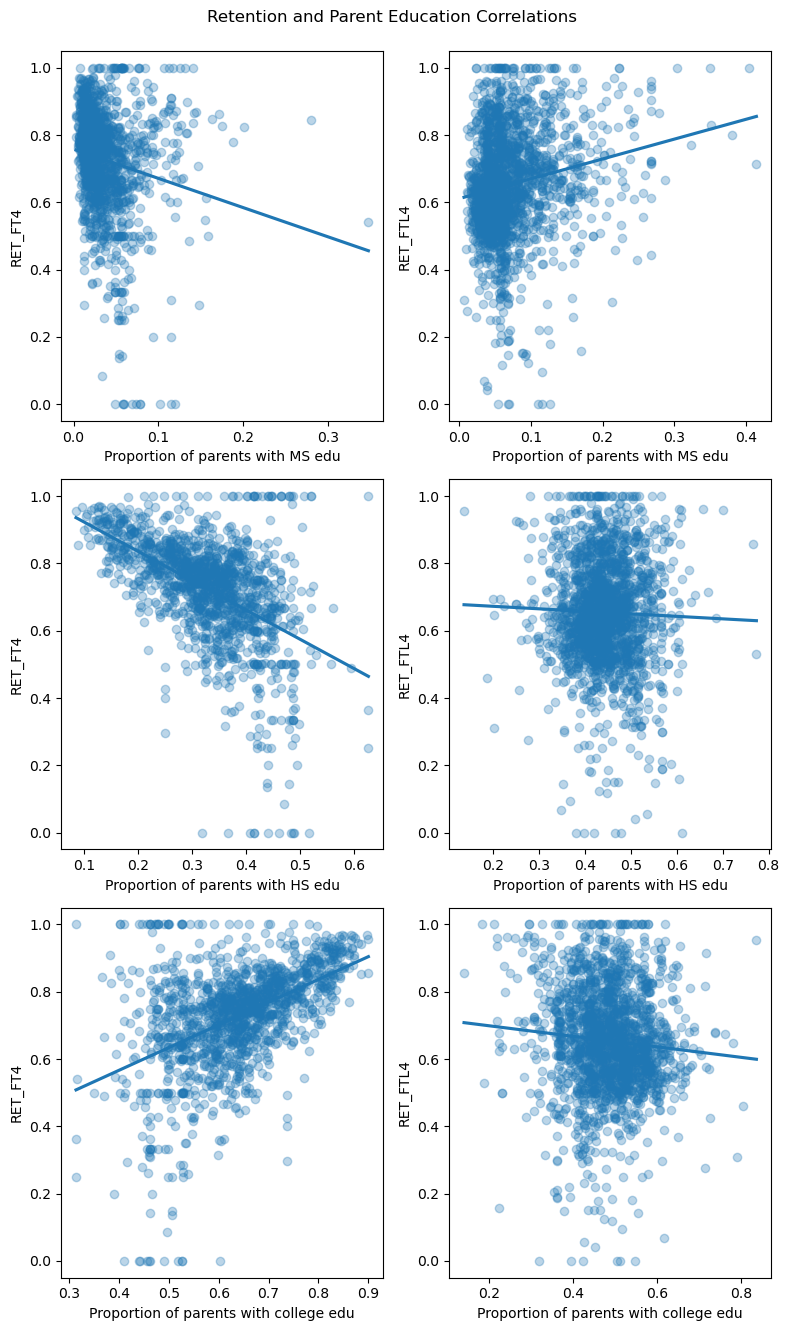

In [25]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.subplots_adjust(hspace=.2)
fig.tight_layout()
fig.suptitle("Retention and Parent Education Correlations ", y= 1.02);

Here we see that parents' middle school education seems have a nonlinear weak relationship with student retention. Parents' highschool and college education seem to be very weakly correlated with retention at less than 4 year institutions.

However, Parents' highschool and college education seems to be strongly correlated with a clear linear relationship with retention at 4 year institutions. Highschool education appears to have a negative correlation while college education has a positive correlationship. This may be because of confounding factors, but the association is clear.

**Based on this, we should include parent HS and college education ```PAR_ED_PCT_HS``` and ```PAR_ED_PCT_PS``` in our final analysis.**

This approach forces us to remove lots of the data. Instead, we can remove all indices with PrivacySuppressed or nulls for each combination of parent education (```PAR_ED_PCT_MS```, ```PAR_ED_PCT_HS```, ```PAR_ED_PCT_PS```) with student retention (```RET_FT4```, ```RET_FTL4```). 

This results in a unique subsample for each combination making their results less comparable, but the samples have more data in them making each test possible more representative of the fully sample.

In [26]:
#select all indices with "PrivacySuppressed" in them for each column individually
edu_indiv_PrivacySuppressed_indices = data[["PAR_ED_PCT_MS", "PAR_ED_PCT_HS", "PAR_ED_PCT_PS"]].\
    apply(lambda col: col.astype(str).str.match("PrivacySuppressed"))

#remove those indices to get sample for each parent education and student retention feature combo
edu_no_PrivacySuppressed_MS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ft4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FT4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_MS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_MS]\
    [["PAR_ED_PCT_MS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_HS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_HS]\
    [["PAR_ED_PCT_HS", "RET_FTL4"]].\
    dropna().\
    astype(float)
edu_no_PrivacySuppressed_PS_ftl4 = data[~edu_indiv_PrivacySuppressed_indices.PAR_ED_PCT_PS]\
    [["PAR_ED_PCT_PS", "RET_FTL4"]].\
    dropna().\
    astype(float)

#check how large our samples are (note that they are larger)
print("One of our samples now has size: ", len(edu_no_PrivacySuppressed_PS_ftl4))

One of our samples now has size:  2538


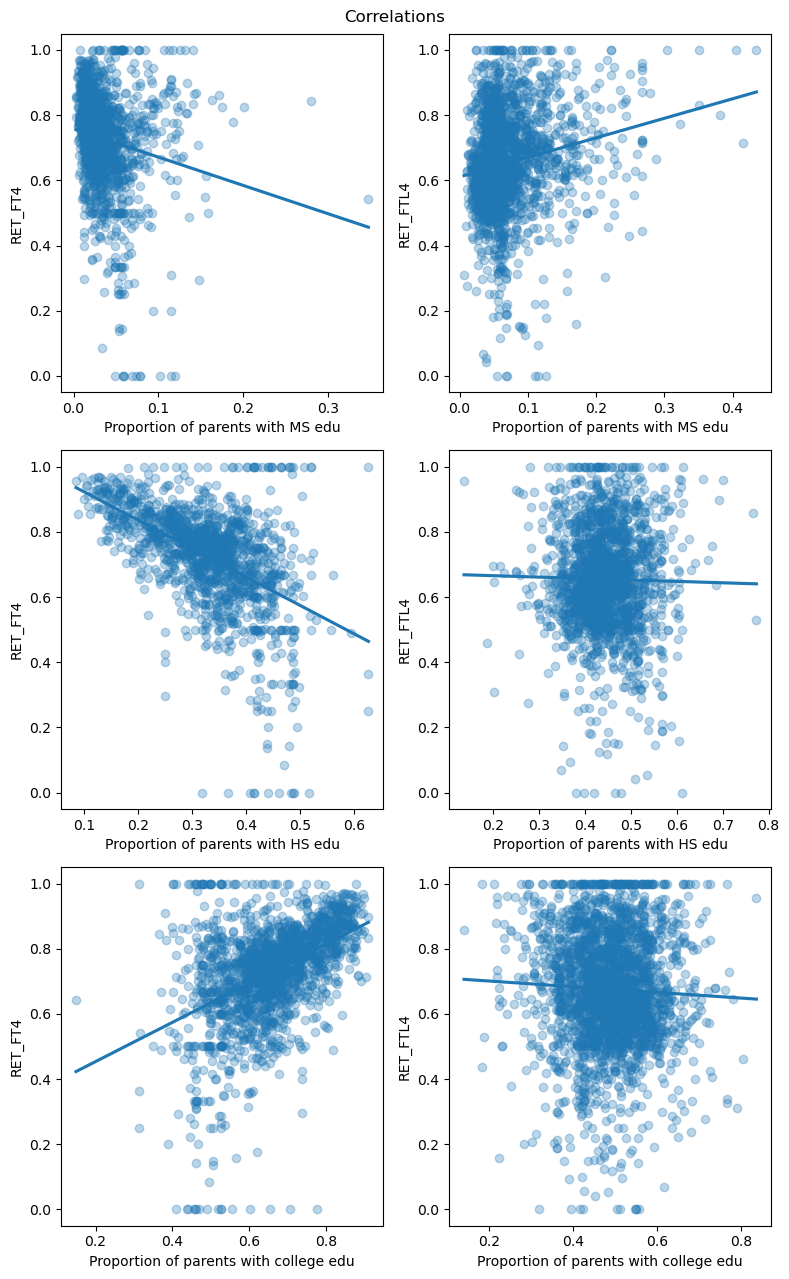

In [27]:
fig, axs = plt.subplots(3, 2, figsize=(8, 13))
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FT4", data = edu_no_PrivacySuppressed_MS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,0].get_position()
pos.y0 += .25
axs[0, 0].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_MS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_MS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("Proportion of parents with MS edu")
pos = axs[0,1].get_position()
pos.y0 += .25
axs[0, 1].set_position(pos)
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FT4", data = edu_no_PrivacySuppressed_HS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_HS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_HS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("Proportion of parents with HS edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FT4", data = edu_no_PrivacySuppressed_PS_ft4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,0])
axs[2,0].set_xlabel("Proportion of parents with college edu")
sns.regplot(x = "PAR_ED_PCT_PS", y = "RET_FTL4", data = edu_no_PrivacySuppressed_PS_ftl4, scatter_kws={'alpha':0.3}, ci=False, ax=axs[2,1])
axs[2,1].set_xlabel("Proportion of parents with college edu")
fig.tight_layout()
fig.suptitle("Correlations");
plt.savefig('figures/parent_edu_corr.png')

**We get roughly the same results as with the previous method, with parents' college education being strongly positively correlated with retention at 4 year institutions and parents' highschool education being negatively correlated. This affirms that we should be using these variables in our final analysis of student retention.**

## Explore Programs Offered

Notice that of the institutions with data, a large proportion offer only a few programs. Upon close inspection, these appear to be highly specialized trade schools

In [28]:
data.PRGMOFR.value_counts()[:10]

1.0     379
2.0     352
3.0     342
4.0     309
5.0     214
6.0     156
7.0     105
9.0      72
8.0      60
10.0     43
Name: PRGMOFR, dtype: int64

In [29]:
data[data.PRGMOFR<=10].INSTNM

17         New Beginning College of Cosmetology
60           Alaska Vocational Technical Center
62                        Alaska Career College
63                  Empire Beauty School-Tucson
64             Carrington College-Phoenix North
                         ...                   
6116     San Joaquin Valley College-Porterville
6118                  Ruben's Five Star Academy
6123         Miller-Motte College-Chattanooga 2
6125          Elite Welding Academy South Point
6126    Zorganics Institute Beauty and Wellness
Name: INSTNM, Length: 2032, dtype: object

Therefore, we may want to explore these low programs offered institutinos separately. 

But there is a caveat: note that ```UNITID``` is the pkey, and that 98 Institutions of the same name are connected to multiple ```UNITID```'s

In [30]:
print("UNITID is the primary key: ", len(data) == len(data.groupby("UNITID")))
print("INSTNM is the primary key: ", len(data) == len(data.groupby("INSTNM")))

UNITID is the primary key:  True
INSTNM is the primary key:  False


We hypothesize that institutions with thh same name ```INSTNM``` are actually the same parent institution with sub-institutions denoted by different ```UNITID```'s.

This would mean that the number of programs offered is undercounted, and we should sum the number of programs offered for each 'parent institution'.

Let us informally explore this hypothesis by plotting how many institutions may have multiple ID's ```UNITID``` under one name ```INSTNM```

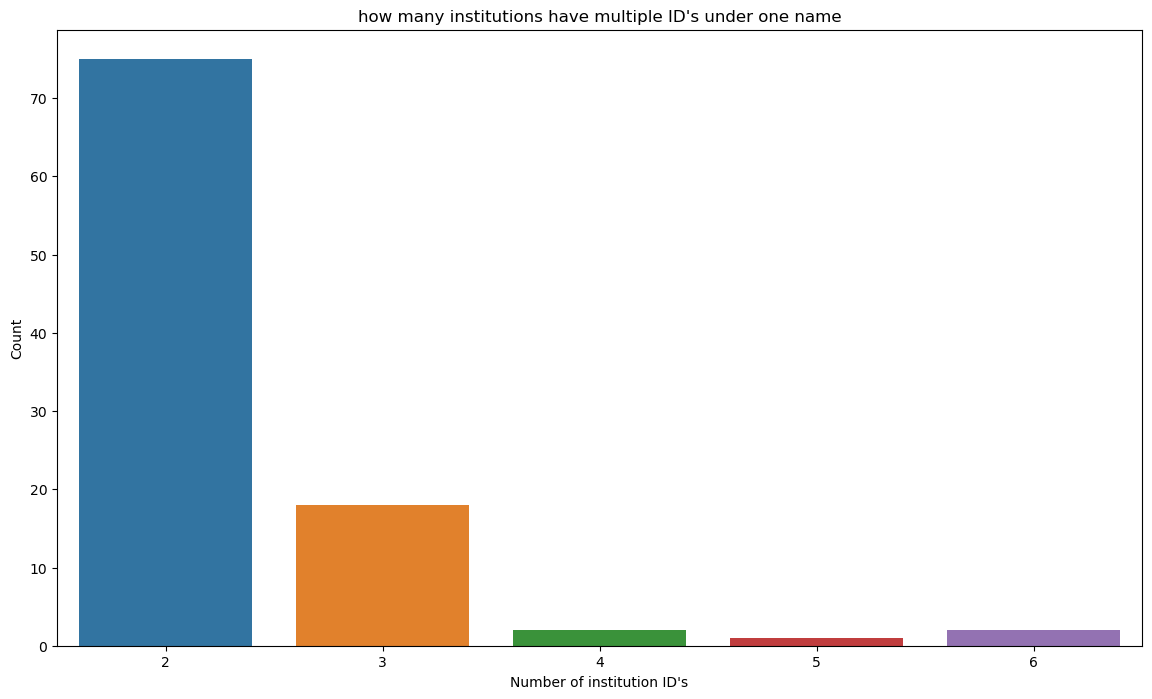

In [31]:
# find the count of institutions by the same name with multiple ID's 
num_UNITID_per_INSTNM = data.groupby("INSTNM").UNITID.count()
multiple_UNITID_per_INSTNM = num_UNITID_per_INSTNM[num_UNITID_per_INSTNM>1]
counts = multiple_UNITID_per_INSTNM.value_counts().sort_index()

# bar plot of how many institution ID's a name is attached to
ax = plt.subplot()
sns.barplot(x=counts.index.values, y=counts)
ax.set_title("how many institutions have multiple ID's under one name")
ax.set_ylabel("Count")
ax.set_xlabel("Number of institution ID's")
ax.set_xticklabels(counts.index.values)
ax.grid(False)
plt.savefig('figures/institution_id.png');

Most institutions are only connected to one institution ID and name, but there are enough names connected to multiple institutions ID's(especially 2 ID's) that they could represent a different relationship with student retention. 

Let's explore these potential parent institutions' ```PRFMOFR``` of the same name separately from ```PRGMOFR``` as a whole.

In [32]:
#aggregate information on institution by each name
instid_per_instnm = data.groupby("INSTNM")[["UNITID", "PRGMOFR", "CITY", "RET_FT4", "RET_FTL4"]]\
    .agg([list, len])\
    .sort_values([("RET_FTL4", "len")], ascending=False)\
    .drop(columns=[(col, "len") for col in ["UNITID", "PRGMOFR", "CITY", "RET_FT4"]])
instid_per_instnm.head()

UNITID  \
                                                                      list   
INSTNM                                                                       
Jersey College           [455196, 45519601, 45519602, 45519603, 4551960...   
Cortiva Institute         [128896, 134574, 215044, 387925, 434308, 438285]   
Columbia College                  [112561, 177065, 217934, 455983, 479248]   
Arthur's Beauty College                   [106360, 106494, 445540, 489830]   
Unitek College                          [459204, 476799, 479424, 45920401]   

                                                PRGMOFR  \
                                                   list   
INSTNM                                                    
Jersey College           [9.0, nan, nan, nan, nan, nan]   
Cortiva Institute        [1.0, 3.0, 1.0, 4.0, 2.0, 4.0]   
Columbia College              [nan, nan, nan, 8.0, 4.0]   
Arthur's Beauty College            [2.0, 2.0, 2.0, 2.0]   
Unitek College                     [nan, 2.0, 2.0, nan]   

                                                                      CITY  \
                                                                      list   
INSTNM                                                                       
Jersey College           [Teterboro, Tampa, Ewing, Jacksonville, Sunris...   
Cortiva Institute        [Cromwell, St. Petersburg, King of Prussia, Po...   
Columbia College         [Sonora, Columbia, Columbia, Vienna, Centreville]   
Arthur's Beauty College      [Fort Smith, Jacksonville, Conway, Jonesboro]   
Unitek College            [Fremont, South San Francisco, Hayward, Fremont]   

                                                 RET_FT4  \
                                                    list   
INSTNM                                                     
Jersey College            [nan, nan, nan, nan, nan, nan]   
Cortiva Institute         [nan, nan, nan, nan, nan, nan]   
Columbia College         [nan, 0.7062, 0.5904, nan, nan]   
Arthur's Beauty College             [nan, nan, nan, nan]   
Unitek College                     [0.85, nan, nan, nan]   

                                                    RET_FTL4      
                                                        list len  
INSTNM                                                            
Jersey College             [0.7021, nan, nan, nan, nan, nan]   6  
Cortiva Institute        [0.875, nan, nan, 0.8, nan, 0.6842]   6  
Columbia College           [0.534, nan, nan, 0.7938, 0.9012]   5  
Arthur's Beauty College     [0.7143, 0.4167, 0.7778, 0.5294]   4  
Unitek College                    [nan, 0.8958, 0.9302, nan]   4

As a sanity check, let's look at Unitek college. From a google search, it is in fact the same University with multiple campuses. 

It would be very difficult verify this for all of the institutions in the dataset, so let us first see if this analysis is worth pursuing by
- examining the correlation between programs offered and student retention rate among these potential parent institutions (by institution name). 
- comparing this correlation with that of between programs offered and student retention rate by institution ID.

In [33]:
#sum the PRGMOFR values for each institution name, 
#treating np.nan's as 1s as that is the minimum number of programs which can be offered
sum_list = lambda row: sum(np.nan_to_num(row.iloc[0], nan=1))
parent_inst_PRGMOFR = instid_per_instnm[[("PRGMOFR", "list")]]\
    .apply(sum_list, axis=1)

#average retention over the sub-institutions
avg_list = lambda row: (np.mean(np.nan_to_num(row.iloc[0], nan=1)), np.mean(np.nan_to_num(row.iloc[1], nan=1)))
parent_inst_RET = instid_per_instnm[[("RET_FT4", "list"), ("RET_FTL4", "list")]]\
    .apply(avg_list, axis=1, result_type="expand")\
    .rename(columns={0:"RET_FT4", 1:"RET_FTL4"})

# join columns for easy plotting
instid_per_instnm = parent_inst_RET.copy()
instid_per_instnm["PRGMOFR"] = parent_inst_PRGMOFR
instid_per_instnm.head()

,RET_FT4,RET_FTL4,PRGMOFR
INSTNM,,,
Jersey College,1.00000,0.95035,14.0
Cortiva Institute,1.00000,0.89320,15.0
Columbia College,0.85932,0.84580,15.0
Arthur's Beauty College,1.00000,0.60955,8.0
Unitek College,0.96250,0.95650,6.0


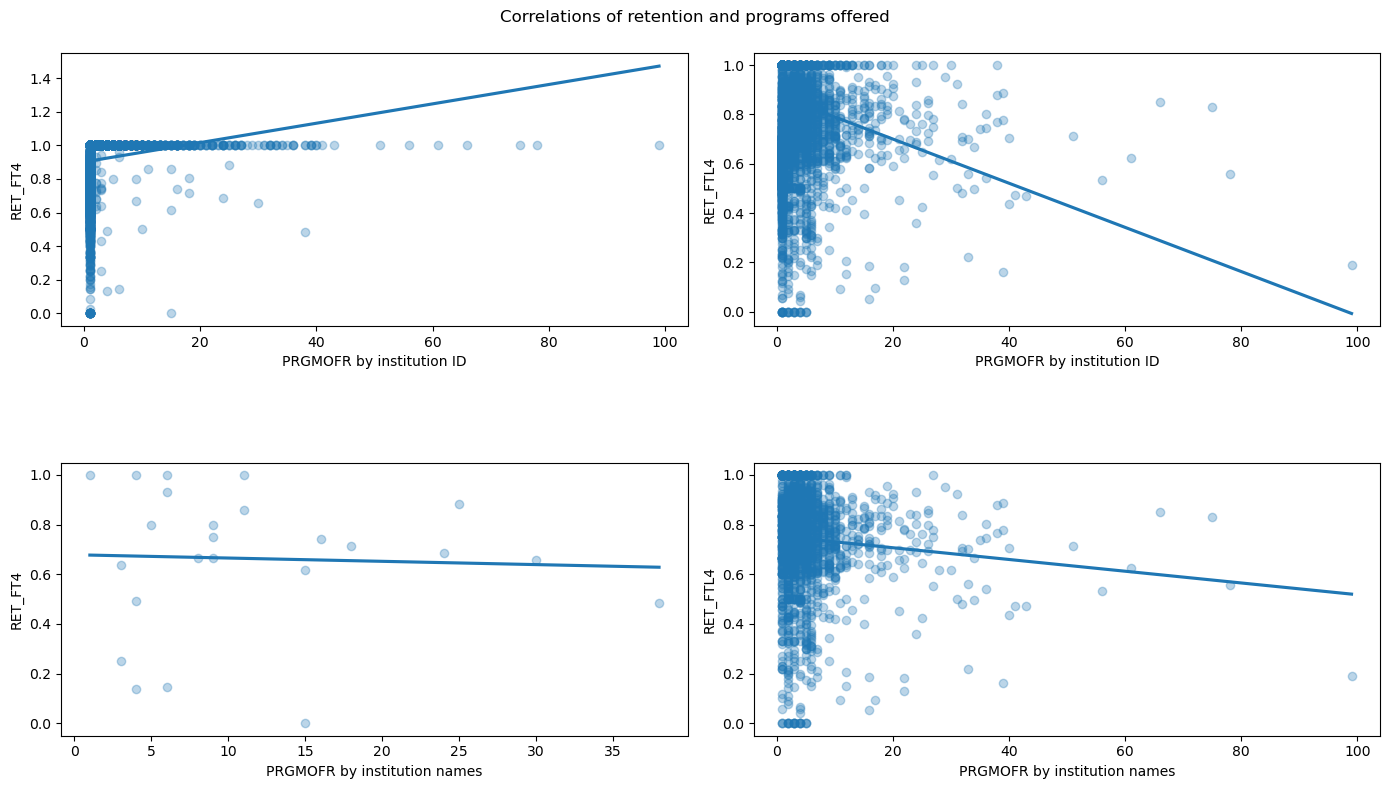

In [34]:
fig, axs = plt.subplots(2, 2)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = instid_per_instnm, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,0])
axs[0,0].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,0].get_position()
pos.y0 += .4
axs[0,0].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = instid_per_instnm, scatter_kws={'alpha':0.3}, ci=False, ax=axs[0,1])
axs[0,1].set_xlabel("PRGMOFR by institution ID")
pos = axs[0,1].get_position()
pos.y0 += .4
axs[0,1].set_position(pos)
sns.regplot(x = "PRGMOFR", y = "RET_FT4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,0])
axs[1,0].set_xlabel("PRGMOFR by institution names")
sns.regplot(x = "PRGMOFR", y = "RET_FTL4", data = data, scatter_kws={'alpha':0.3}, ci=False, ax=axs[1,1])
axs[1,1].set_xlabel("PRGMOFR by institution names")
fig.tight_layout()
fig.subplots_adjust(hspace=.5)
fig.suptitle("Correlations of retention and programs offered");
plt.savefig('figures/institution_id_corr.png')

Reasons for further exploration:
- Note that student retention on the y axis is strictly boundeded within [0, 1], including retention by our hypothesized parent institutions (instition name). This suggests that instititution ID's with the same corresponding names are, in fact, parent institutions. 

In [35]:
print("max retention of a parent institution: ", instid_per_instnm[["RET_FT4", "RET_FTL4"]].max().max())
print("min retention of a parent institution: ", instid_per_instnm[["RET_FT4", "RET_FTL4"]].min().min())

max retention of a parent institution:  1.0
min retention of a parent institution:  0.0


Reasons for skepticism:
- However, looking at the scatterplots, the relationships are not roughly linear and the correlations are weak so we will not pursue this variable further.

- It shuold be noted that some potential parent institutions could have more sub-institutions / ID's which aren't recorded. Similarly institutions could have the same name by conincedence and not be related. 

- Furthermore, a large proportion of ```PRGMOFR``` is null, meaning that our analysis on the non-nulls may not be representative of the sample and therefore of the population.

**Therefore, ```PRGMOFR``` cannot be proven to be significantly associated with student retention features ```RET_FT4``` and ```RET_FTL4```. If further information on parent-institutions becomes available, we can pursue this idea again.**

## Feature Analysis on Numerical variables

Within the dataset, there are many variables that include "Privacy Suppressed" values. **Due to the variability of these values, we have to exclude the these variables from the analysis since our dataset will be very small if we wanted to include them.**

In [36]:
fouryr_features = ['HIGHDEG', 'ADM_RATE', 'ST_FIPS', 'LOCALE', 'SAT_AVG', 'CCUGPROF', 'CCSIZSET',
            'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN' , 
            'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA','UGDS_UNKN', 
            'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'INEXPFTE', 'AVGFACSAL' , 'PFTFAC',
            'PCTPELL', 'PCTFLOAN', 'AGE_ENTRY', 
            'FAMINC','MD_FAMINC', 'ADMCON7', 'UGDS_MEN', 'UGDS_WOMEN', 'ANP',
            ## four year specific
            'RET_FT4']

clean_data = combine_columns(data, 'NPT4_PUB', 'NPT4_PRIV', 'ANP')[fouryr_features].dropna()

In [37]:
compute_feature_importance(clean_data, 'RET_FT4')

,Feature,Importance
4,SAT_AVG,0.265172
19,AVGFACSAL,0.137172
5,CCUGPROF,0.074665
21,PCTPELL,0.045421
24,FAMINC,0.042259
6,CCSIZSET,0.039094
25,MD_FAMINC,0.031908
10,UGDS_ASIAN,0.029531
18,INEXPFTE,0.023393
17,TUITIONFEE_OUT,0.020327


**Based on the feature analysis with four-year retention rates, `SAT_AVG` and `AVGFASCAL` have some importance in determining retention rates.**

In [38]:
less_fouryr_features = ['HIGHDEG', 'ADM_RATE', 'ST_FIPS', 'LOCALE', 'SAT_AVG', 'CCUGPROF', 'CCSIZSET',
            'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN' , 
            'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA','UGDS_UNKN', 
            'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'INEXPFTE', 'AVGFACSAL' , 'PFTFAC',
            'PCTPELL', 'PCTFLOAN', 'AGE_ENTRY', 
            'FAMINC','MD_FAMINC', 'ADMCON7', 'UGDS_MEN', 'UGDS_WOMEN', 'ANP',
            ## less than four year specific
            'RET_FTL4']

clean_data = combine_columns(data, 'NPT4_PUB', 'NPT4_PRIV', 'ANP')[less_fouryr_features].dropna()

In [39]:
compute_feature_importance(clean_data, 'RET_FTL4')

,Feature,Importance
9,UGDS_HISP,0.138890
11,UGDS_AIAN,0.116873
5,CCUGPROF,0.111193
8,UGDS_BLACK,0.096175
12,UGDS_NHPI,0.087133
14,UGDS_NRA,0.066514
29,ANP,0.044462
3,LOCALE,0.039586
18,INEXPFTE,0.038352
21,PCTPELL,0.021900


**Based on the feature analysis with less-than-four-year retention rates, the diversity of ethnicity has significant importance in determining retention rates.**